In [85]:
import numpy as np
import jax.numpy as jnp
#from jax import grad, jit, vmap
from scipy.integrate import dblquad
import trimesh as tm

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr

import matplotlib.pyplot as plt

## Problem description

The goal is to solve the Laplace equation with Dirichlet boundary conditions in 2D on a square domain using the finite element method. 

The Laplace equation is given by: 

$\nabla^2 u = 0$ on $\Omega$

where $\Omega$ is the domain of interest.

and the Dirichlet boundary conditions are given by:

$u = g(x,y)$ on $\partial \Omega$

where $\partial \Omega$ is the boundary of the domain.

We will solve this equation using the Garlekin method of weighted residuals. The weak form of the Laplace equation is given by:

$\int_{\Omega} \nabla^2 u v d\Omega = 0$

where $v$ is a test function.

After applying Green's first identity, we get:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega - \int_{\partial \Omega} \nabla u \cdot n v d\partial \Omega = 0$

where $n$ is the outward normal vector to the boundary.

In this case, we assume that our test function vanishes on the boundary, i.e. $v = 0$ on $\partial \Omega$. This simplifies the equation to:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega = 0$

And the boundary conditions is enforced by setting $u = g(x,y)$ on $\partial \Omega$.

​

## Setup of Quadratic Basis Functions on a Triangle


To interpolate $u$ in our triangular elements, we will use a second order Lagrange basis function. 

For a quadratic (second-degree) interpolation on a triangle, we need six nodes:
- Three nodes at the vertices of the triangle,
- Three nodes at the midpoints of the edges.


Let’s label these nodes as follows:
- $n_1$ vertex at $(0,0)$,
- $n_2$ vertex at $(1,0)$,
- $n_3$ vertex at $(0,1)$,
- $n_4$ midpoint of edge between n1 and n2 at $(0.5,0)$,
- $n_5$ midpoint of edge between n2 and n3 at $(0.5,0.5)$,
- $n_6$ midpoint of edge between n1 and n3 at $(0,0.5)$.


## Quadratic Basis Functions in Terms of $u$ and $v$

The quadratic basis functions are designed so that each basis function is equal to 1 at its associated node and 0 at all other nodes. For a quadratic triangular element, the basis functions $N_{i}(u,v)$ can be constructed as follows:

- $N_1(u,v) = 1 - 3u - 3v + 2u^2 + 4uv + 2v^2$
- $N_2(u,v) = u(2u - 1)$
- $N_3(u,v) = v(2v - 1)$
- $N_4(u,v) = 4u(1 - u - v)$
- $N_5(u,v) = 4uv$
- $N_6(u,v) = 4v(1 - u - v)$

where $u$ and $v$ are the coordinates of the point in the reference triangle.

Each basis function is associated with a node, where it is equal to 1, and 0 at all other nodes.


In [86]:
#Start by creating the basis functions in local coordinates
def basis_fn_1(u,v): return 1 - 3*u - 3*v + 2*u**2 + 4*u*v + 2*v**2
def basis_fn_2(u,v): return u * (2*u - 1)
def basis_fn_3(u,v): return v * (2*v - 1)
def basis_fn_4(u,v): return 4*u*(1-u-v)
def basis_fn_5(u,v): return 4*u*v
def basis_fn_6(u,v): return 4*v*(1-u-v)

#Compute the gradient of each basis function:
def grad_basis_fn_1(u,v): return np.array([-3 + 4*u + 4*v, -3 + 4*u + 4*v]).astype(np.float64)
def grad_basis_fn_2(u,v): return np.array([4*u - 1, 0]).astype(np.float64)
def grad_basis_fn_3(u,v): return np.array([0, 4*v - 1]).astype(np.float64)
def grad_basis_fn_4(u,v): return np.array([4 - 8*u - 4*v, -4*u]).astype(np.float64)
def grad_basis_fn_5(u,v): return np.array([4*v, 4*u]).astype(np.float64)
def grad_basis_fn_6(u,v): return np.array([-4*v, 4 - 4*u - 8*v]).astype(np.float64)

#Store the gradient of the basis functions in a list
grad_basis_fn_lst = [
    grad_basis_fn_1, 
    grad_basis_fn_2, 
    grad_basis_fn_3,
    grad_basis_fn_4,
    grad_basis_fn_5,
    grad_basis_fn_6
]
n_local_basis_fn = len(grad_basis_fn_lst)

#Create the functions that correspond to the product of the basis functions
def grad_basis_fn_product(u,v, grad_basis_fn_lst, i, j):
    return np.dot(grad_basis_fn_lst[i](u,v), grad_basis_fn_lst[j](u,v))

#Integrate the product of the gradient of the basis functions over the reference triangle
def integrate_basis_fn_product(i, j, grad_basis_fn_lst):
    return dblquad(grad_basis_fn_product, 0, 1, lambda u: 0, lambda u: 1-u, args=(grad_basis_fn_lst, i,j))[0]

In [87]:
#Compute all the entries of the local stiffness matrix
local_stiffness_matrix = np.zeros((n_local_basis_fn, n_local_basis_fn))
for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
    
        #The stiffness matrix is symmetric, so we only need to compute the upper triangular part
        K_ij = integrate_basis_fn_product(i,j, grad_basis_fn_lst)
        local_stiffness_matrix[i,j] = K_ij
        local_stiffness_matrix[j,i] = K_ij


In [88]:
print(local_stiffness_matrix.shape)

(6, 6)


In [89]:
#Load the square triangulated mesh
mesh = tm.load_mesh('square.obj')

#Make sure that the origin of the mesh is 0,0
mesh.vertices -= mesh.vertices.min(axis=0)

inner_edge_mask = np.ones(len(mesh.edges_sorted), dtype=bool)
inner_edge_mask[tm.grouping.group_rows(mesh.edges_sorted, require_count=1)] = False

#Get the edges located at the boundary of the mesh
mesh.boundary_edges = mesh.edges_sorted[~inner_edge_mask]

#Get the vertices located at the boundary of the mesh
mesh.boundary_vertices_idx = np.unique(mesh.boundary_edges)

#Get the position of the edge midpoints
mesh.edge_midpoints = mesh.vertices[mesh.edges_unique].mean(axis=1)


#Create a unique idx for each edge and relate it to the position of the edge in the mesh.edges_unique array.
mesh.unique_idx_to_edge_idx = {
    tuple(sorted(v)): i for i, v in enumerate(mesh.edges_unique)
}

#For each face we need to know the global indices of the 3 midpoints on its edges
mesh.face_midpoints_idx = np.array([
    [
        mesh.unique_idx_to_edge_idx[tuple(sorted([face[0], face[1]]))],
        mesh.unique_idx_to_edge_idx[tuple(sorted([face[1], face[2]]))],
        mesh.unique_idx_to_edge_idx[tuple(sorted([face[2], face[0]]))]
    ] for face in mesh.faces
])

#Also get the indices of the edge midpoints that are located at the boundary
mesh.boundary_midpoints_idx = np.array([
    mesh.unique_idx_to_edge_idx[tuple(sorted([mesh.boundary_edges[i, 0], mesh.boundary_edges[i, 1]]))]
    for i in range(len(mesh.boundary_edges))
])

#Keep track of the number of vertices, faces, midpoints and boundary vertices
n_vertices = len(mesh.vertices)
n_midpoints = len(mesh.edge_midpoints)
n_faces = len(mesh.faces)
n_boundary_vertices = len(mesh.boundary_vertices_idx)
n_boundary_midpoints = len(mesh.boundary_midpoints_idx)

#Apply the boundary condition to the boundary vertices and boundary midpoints

##Store the value of the field at the boundary points
mesh.vertex_boundary_values =   np.zeros(n_boundary_vertices)
mesh.midpoint_boundary_values = np.zeros(n_boundary_midpoints)

boundary_vertex_pos =   mesh.vertices[mesh.boundary_vertices_idx]
boundary_midpoint_pos = mesh.edge_midpoints[mesh.boundary_midpoints_idx]

mesh.vertex_boundary_values     = np.where(boundary_vertex_pos[:, 0]   == 1, np.sin(boundary_vertex_pos[:, 1]* np.pi),    0.0)[:, np.newaxis]
mesh.midpoint_boundary_values   = np.where(boundary_midpoint_pos[:, 0] == 1, np.sin(boundary_midpoint_pos[:, 1] * np.pi), 0.0)[:, np.newaxis]

In [90]:
# Create an array that combines for each face the indices of the vertices and midpoints
face_idx = np.column_stack((mesh.faces, mesh.face_midpoints_idx + n_vertices))


#Construct the global stiffness matrix, this matrix will be sparse, 
shape_global_stiffness_matrix = (n_faces * n_local_basis_fn, n_vertices + n_midpoints)

# The entries in the local stiffness matrix have local indices i,j: K_ij. 
# This local indices have to be transformed into global indices I,J: K_IJ

# The map is given by the following relation: 
#   I = face_idx * n_local_basis_fn + i
#   J = vertex_idx


# Compute the column indices of the sparse stiffness matrix 
J = np.tile(face_idx, n_local_basis_fn)

# Compute the row indices of the sparse stiffness matrix 
I = np.arange(n_faces * n_local_basis_fn * n_local_basis_fn) // n_local_basis_fn
I = I.reshape(n_faces,  n_local_basis_fn * n_local_basis_fn)

# Create the data matrix of the sparse stiffness matrix
data = np.tile(local_stiffness_matrix.flatten(), n_faces).reshape(n_faces, n_local_basis_fn * n_local_basis_fn)

# Create the sparse stiffness matrix
global_stiffness_matrix = csc_matrix((data.flatten(), (I.flatten(), J.flatten())), shape=shape_global_stiffness_matrix)

In [91]:
# Now we need to enforce the Dirichlet boundary conditions

# To do so, we delete all the columns that correspond to the boundary vertices
boundary_vertex_mask = np.zeros(global_stiffness_matrix.shape[1], dtype=bool)
boundary_vertex_mask[mesh.boundary_vertices_idx] = True

boundary_midpoint_mask = np.zeros(global_stiffness_matrix.shape[1], dtype=bool) 
boundary_midpoint_mask[mesh.boundary_midpoints_idx + n_vertices] = True

interior_mask = np.ones(global_stiffness_matrix.shape[1], dtype=bool)
interior_mask[mesh.boundary_vertices_idx]  = False
interior_mask[mesh.boundary_midpoints_idx + n_vertices] = False


# Select the columns that correspond to the interior vertices
global_stiffness_matrix_with_BC = global_stiffness_matrix[:, interior_mask]

# Select the columns that correspond to the boundary vertices
boundary_vertex_columns   = -global_stiffness_matrix[:, boundary_vertex_mask]
boundary_midpoint_columns = -global_stiffness_matrix[:, boundary_midpoint_mask]


# Compute the right-hand side of the linear system
rhs = boundary_vertex_columns @ mesh.vertex_boundary_values + boundary_midpoint_columns @ mesh.midpoint_boundary_values

In [92]:
# Now we just have to solve the system of equations, to get the coefficients of the basis functions at the interior points
sol_interior = lsqr(global_stiffness_matrix_with_BC, rhs)[0]

#Select only the solution at the face vertices and not the edge midpoints
sol_interior = sol_interior[: n_vertices - n_boundary_vertices]

# We regroup the solution of the interior points with the boundary points
sol = np.zeros(n_vertices)

resized_boundary_vertex_mask = boundary_vertex_mask[:n_vertices]
sol[resized_boundary_vertex_mask]  = mesh.vertex_boundary_values.flatten()
sol[~resized_boundary_vertex_mask] = sol_interior

[]

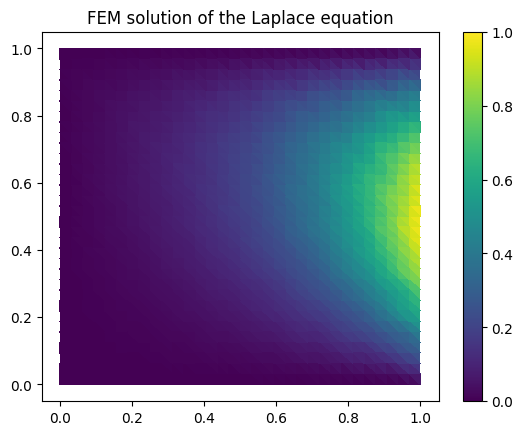

In [93]:
#Plot the solution
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, sol, shading='flat', vmin=0, vmax=1)
plt.colorbar()
plt.title('FEM solution of the Laplace equation')
plt.plot()

[]

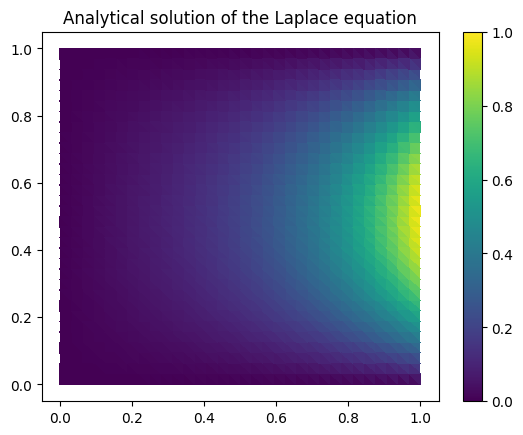

In [94]:
analytical_solution = np.sinh(mesh.vertices[:, 0] * np.pi)[:, np.newaxis] * np.sin(mesh.vertices[:, 1] * np.pi)[:, np.newaxis] / np.sinh(np.pi)



plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, analytical_solution.flatten(), shading='flat', vmin=0, vmax=1)
plt.colorbar()
plt.title('Analytical solution of the Laplace equation')
plt.plot()

[]

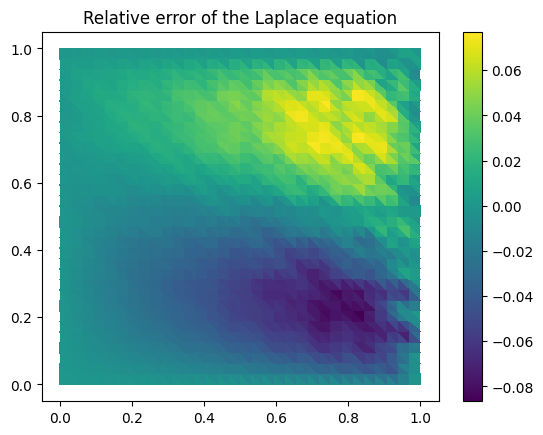

In [95]:
#Compute the relative error
relative_error = (sol - analytical_solution.flatten()) 

plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, relative_error, shading='flat')
plt.colorbar()
plt.title('Relative error of the Laplace equation')
plt.plot()